In [1]:
import sys
import os
sys.path.append(os.path.abspath("/home/shiting/code/closed-loop/closed_circuit"))
from compartments import *

In [2]:
from tqdm import tqdm 
from p_tqdm import p_map
def compute_parameters(param):
    C_p, Za_p, R_p,Emax_rv, Emin_rv = param#, Emax_rv, Emin_rv
    rv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax =Emax_rv, Emin = Emin_rv, V0 = 10, T = T, deltat = 0.01) # Ks, V0 ,T
    cap_p=PressureSystem(C_p, Za_p, R_p)
    
    def dydt(t, y):
        v_lv = y[0]
        v_la = y[1]
        q_av = y[2]
        q_mv = y[3]
        xi_av = y[4]
        xi_mv = y[5]
        #pressure of capillaries in systemic circulation
        pa = y[6]
        v_rv = y[7]
        v_ra = y[8]
        q_tv = y[9]
        q_pv = y[10]
        xi_tv = y[11]
        xi_pv = y[12]
        #pressure of capillaries in pulmonary circulation
        pb = y[13]

        #calculate parameters
        #systemic
        p_la = la.p(v_la,t)
        p_lv = lv.p(v_lv,t)
        #p_aa: pressure at the coupling point of av and capillaries
        p_aa = cap_s.pi(q_av,pa)
        #pulmonary
        p_ra = ra.p(v_ra,t)
        p_rv = rv.p(v_rv,t)
        #q_cap2: flow out the capillaries of pulmonary circulation
        q_cap2 = cap_p.qout(pb,p_la)
        #p_pa: pressure at the coupling point of pv and capillaries
        p_pa = cap_p.pi(q_tv,pb)
        #q_cap1: flow out the capillaries of systemic circulation
        q_cap1 = cap_s.qout(pa,p_ra)

        #derivative
        #la
        dv_la = la.dv(t,v_la,q_cap2,q_mv)
        dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
        dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
        #lv
        dv_lv = lv.dv(t,v_lv,q_mv,q_av)
        dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
        dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
        #cap sys
        dpa = cap_s.dp_original(t,pa,q_av,p_ra)
        #ra
        dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
        dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
        dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
        #rv
        dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
        dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
        dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
        #cap pul
        dpb = cap_p.dp_original(t,pb,q_pv,p_la)

        #derivative vector
        dy = np.array([dv_lv, dv_la, 
                       dq_av, dq_mv, 
                       dxi_av, dxi_mv, 
                       dpa, 
                       dv_rv, dv_ra, 
                       dq_tv, dq_pv, 
                       dxi_tv, dxi_pv, 
                       dpb])
        return dy

    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
    
    sol.t = sol.t[int(T*1000):int(T*1100)]
    v_lv = sol.y[0][int(T*1000):int(T*1100)]
    v_la = sol.y[1][int(T*1000):int(T*1100)]
    q_av = sol.y[2][int(T*1000):int(T*1100)]
    q_mv = sol.y[3][int(T*1000):int(T*1100)]
    xi_av = sol.y[4][int(T*1000):int(T*1100)]
    xi_mv = sol.y[5][int(T*1000):int(T*1100)]
    pa = sol.y[6][int(T*1000):int(T*1100)]
    v_rv = sol.y[7][int(T*1000):int(T*1100)]
    v_ra = sol.y[8][int(T*1000):int(T*1100)]
    q_tv = sol.y[9][int(T*1000):int(T*1100)]
    q_pv = sol.y[10][int(T*1000):int(T*1100)]
    xi_tv = sol.y[11][int(T*1000):int(T*1100)]
    xi_pv = sol.y[12][int(T*1000):int(T*1100)]
    pb = sol.y[13][int(T*1000):int(T*1100)]
    
    p_lv, p_rv, p_la, p_ra, p_ao, p_pa = [], [], [], [], [], []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_lv.append(lv.p(v_lv[j], i))
        p_la.append(la.p(v_la[j], i))
        p_ra.append(ra.p(v_ra[j], i))
        p_rv.append(rv.p(v_rv[j], i))
        p_ao.append(cap_s.pi(q_av[j], pa[j]))
        p_pa.append(cap_p.pi(q_pv[j], pb[j]))
    p_lv, p_rv, p_ao, p_pa, p_la, p_ra= np.array(p_lv)/1333, np.array(p_rv)/1333, np.array(p_ao)/1333, np.array(p_pa)/1333, np.array(p_la)/1333, np.array(p_ra)/1333
    return p_lv, p_rv, p_ao, p_pa, v_lv, v_rv, q_av, q_mv, q_pv
if __name__ == "__main__":
    T = 0.8
    t_end=9
    t = [0,t_end]
    t_step = 0.01
    t_span = np.arange(0,t_end,t_step)
    original = np.array([0.00272, 26.64387, 165.27640, 0.8, 0.04 ])
    C = np.array([0.00272*1.01, 26.64387, 165.27640, 0.8, 0.04  ])
    R = np.array([0.00272, 26.64387, 165.27640*1.01, 0.8, 0.04  ])
    Za = np.array([0.00272, 26.64387*1.01, 165.27640, 0.8, 0.04  ])
    Emax_rv = np.array([0.00272, 26.64387, 165.27640 , 0.8*1.01, 0.04 ])
    Emin_rv = np.array([0.00272, 26.64387, 165.27640 , 0.8, 0.04*1.01 ])
    params = np.vstack((original, C, R, Za, Emax_rv, Emin_rv))


    lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 3, Emin = 0.08, V0 = 10,T = T, deltat = 0.01)# V0 (mL), T (s)
    la=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.17, Emin = 0.08,V0 = 3,T = T, deltat = 0.01, delay = 0.85*T) # V0 (mL), T (s)
    ra=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.15, Emin = 0.04, V0 = 3, T = T, deltat = 0.01, delay = 0.85*T) # Ks, V0, T
    av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, Kvo = 0.12,Kvc = 0.15, p_oc = 0)
    mv=ValveinP(density = 1.06,eff_length =1.9,Aann = 5, Kvo = 0.3,Kvc = 0.4, p_oc = 0)
    tv=ValveinP(1.06,2,6, 0.3,0.4, 0) #poc (mmHg)
    pv=ValveinP(1.06,1.9,2.8, 0.2,0.2, 0) #poc
    cap_s=PressureSystem(0.00061, 103.44867, 1471.26289)

    results = np.array(p_map(compute_parameters, params, num_cpus=32))

  0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
def data_processing(v_lv, v_rv, p_lv, p_rv, p_pv):
    max_volume_rv = max(v_rv)
    min_volume_rv = min(v_rv)
    sv_rv = max_volume_rv - min_volume_rv
    rvef = sv_rv / max_volume_rv
    max_volume_lv = max(v_lv)
    
    min_volume_lv = min(v_lv)
    sv_lv = max_volume_lv - min_volume_lv
    lvef = sv_lv / max_volume_lv
    maxplv = max(p_lv)
    maxprv = max(p_rv)
    maxppv = max(p_pv)
    minppv = min(p_pv)
    return maxplv, maxprv, maxppv, minppv, max_volume_rv, min_volume_rv, max_volume_lv, min_volume_lv, sv_rv, sv_lv, rvef, lvef

In [4]:
p_lv, p_rv, p_ao, p_pa, v_lv, v_rv, q_av, q_mv, q_pv = results[:, 0], results[:, 1], results[:, 2], results[:, 3], results[:, 4], results[:, 5], results[:, 6], results[:, 7], results[:, 8]
    
function = np.array(p_map(data_processing, v_lv, v_rv, p_lv, p_rv, p_pa, num_cpus = 32))

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
lv_indices = [0, 6,7,9,11]
rv_indices = [1,2,3,4,5,8,10]

In [6]:
fun_lv = function[:,lv_indices]
fun_rv = function[:,rv_indices]

In [7]:
dC = 0.01*0.00272/0.00272
dZa = 0.01*26.64387/26.64387
dR = 0.01*165.27640/165.27640
dEmax = 0.01*0.8/0.8
dEmin = 0.01*0.04/0.04

In [8]:
dyC = (function[1]-function[0])/function[0]
dyR = (function[2]-function[0])/function[0]
dyZa = (function[3]-function[0])/function[0]
dyEmax = (function[4]-function[0])/function[0]
dyEmin = (function[5]-function[0])/function[0]

In [9]:
dyC_lv = (fun_lv[1]-fun_lv[0])/fun_lv[0]
dyR_lv = (fun_lv[2]-fun_lv[0])/fun_lv[0]
dyZa_lv = (fun_lv[3]-fun_lv[0])/fun_lv[0]
dyEmax_lv = (fun_lv[4]-fun_lv[0])/fun_lv[0]
dyEmin_lv = (fun_lv[5]-fun_lv[0])/fun_lv[0]
dyC_rv = (fun_rv[1]-fun_rv[0])/fun_rv[0]
dyR_rv = (fun_rv[2]-fun_rv[0])/fun_rv[0]
dyZa_rv = (fun_rv[3]-fun_rv[0])/fun_rv[0]
dyEmax_rv = (fun_rv[4]-fun_rv[0])/fun_rv[0]
dyEmin_rv = (fun_rv[5]-fun_rv[0])/fun_rv[0]

In [10]:
stacked_array_lv = np.vstack((dyC_lv, dyZa_lv, dyR_lv, dyEmax_lv, dyEmin_lv)).T * 100
stacked_array_rv = np.vstack((dyC_rv, dyZa_rv, dyR_rv, dyEmax_rv, dyEmin_rv)).T * 100
stacked_array = np.vstack((dyC, dyZa, dyR, dyEmax, dyEmin)).T * 100

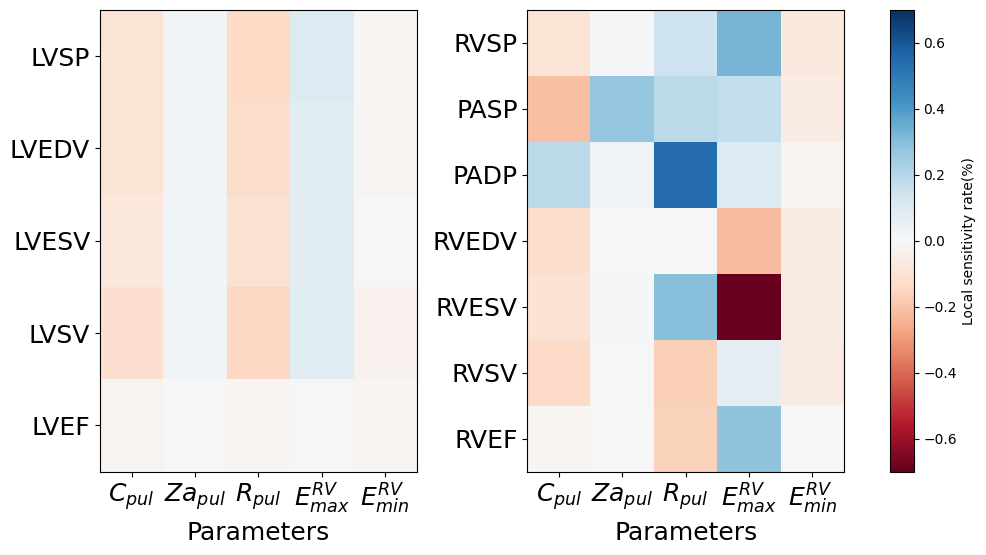

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': 0.35})
vmin, vmax = -0.7, 0.7
im1 = axs[0].imshow(stacked_array_lv, cmap='RdBu', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_yticks(np.arange(5))
axs[0].set_yticklabels(['LVSP', 'LVEDV', 'LVESV', 'LVSV', 'LVEF'], fontsize=18)
axs[0].set_xticks(np.arange(5))
axs[0].set_xticklabels([r'$C_{pul}$', r'$Za_{pul}$', r'$R_{pul}$', r'$E_{max}^{RV}$', r'$E_{min}^{RV}$'], fontsize=18)
axs[0].set_xlabel('Parameters', fontsize=18)

im2 = axs[1].imshow(stacked_array_rv, cmap='RdBu', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_yticks(np.arange(7))
axs[1].set_yticklabels(['RVSP', 'PASP', 'PADP', 'RVEDV', 'RVESV', 'RVSV', 'RVEF'], fontsize=18)
axs[1].set_xticks(np.arange(5))
axs[1].set_xticklabels([r'$C_{pul}$', r'$Za_{pul}$', r'$R_{pul}$', r'$E_{max}^{RV}$', r'$E_{min}^{RV}$'], fontsize=18)
axs[1].set_xlabel('Parameters', fontsize=18)

fig.colorbar(im1, ax= np.array([axs[0],axs[1]]), label='Local sensitivity rate(%)')

plt.savefig('local.svg', format='svg')

plt.show()

In [12]:
flat_array = stacked_array.flatten()

indices = np.argpartition(np.abs(flat_array), -50)[-50:]

sorted_indices = indices[np.argsort(-np.abs(flat_array[indices]))]

max_values = flat_array[sorted_indices]
positions = np.unravel_index(sorted_indices, stacked_array.shape)
result = [] 
mapping = {
    0: 'LVSP',
    1: 'RVSP',
    2: 'PASP',
    3: 'PADP',
    4: 'RVEDV',
    5: 'RVESV',
    6: 'LVEDV',
    7: 'LVESV',
    8: 'RVSV',
    9: 'LVSV',
    10: 'RVEF',
    11: 'LVEF'
}

for k in positions[0]:
    result.append(mapping.get(k, None))
label = []
for j in positions[1]:
    if j == 0:
        label.append("dyC")
    elif j == 1:
        label.append("dyZa")
    elif j == 2:
        label.append("dyR")
    elif j == 3:
        label.append("dyEmax")
    elif j == 4:
        label.append("dyEmin")
    else:
        label.append(None) 
for i in range(50):
    print(f"Value: {round(max_values[i],2)}, Position: {result[i],label[i]}")

Value: -0.74, Position: ('RVESV', 'dyEmax')
Value: 0.54, Position: ('PADP', 'dyR')
Value: 0.32, Position: ('RVSP', 'dyEmax')
Value: 0.3, Position: ('RVESV', 'dyR')
Value: 0.28, Position: ('RVEF', 'dyEmax')
Value: 0.27, Position: ('PASP', 'dyZa')
Value: -0.22, Position: ('RVEDV', 'dyEmax')
Value: -0.21, Position: ('PASP', 'dyC')
Value: 0.19, Position: ('PASP', 'dyR')
Value: 0.18, Position: ('PADP', 'dyC')
Value: 0.17, Position: ('PASP', 'dyEmax')
Value: -0.16, Position: ('RVSV', 'dyR')
Value: -0.16, Position: ('RVEF', 'dyR')
Value: -0.15, Position: ('LVSV', 'dyR')
Value: 0.15, Position: ('RVSP', 'dyR')
Value: -0.14, Position: ('LVSP', 'dyR')
Value: -0.13, Position: ('RVSV', 'dyC')
Value: -0.13, Position: ('LVEDV', 'dyR')
Value: -0.12, Position: ('RVEDV', 'dyC')
Value: -0.12, Position: ('LVSV', 'dyC')
Value: -0.11, Position: ('LVESV', 'dyR')
Value: -0.1, Position: ('RVESV', 'dyC')
Value: -0.1, Position: ('LVEDV', 'dyC')
Value: -0.1, Position: ('LVSP', 'dyC')
Value: 0.1, Position: ('LVSP'